<a href="https://colab.research.google.com/github/VictoriaTejera/Estrategias-Comerciales-con-Datos/blob/main/Demand_Forecasting_student.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objective

The objective of this notebook, is to learn how to transform a time-series problem (demand forecasting) into a tabular one.

For this we will use the M5 competition dataset, large and popular dataset.

In [ ]:
# !pip install -q eccd_datasets pygradus

In [ ]:
STUDENT_NAME = "Isabela Simões"
COURSE_NAME = "eccd-oct22"
EXERCISE_NAME = "demand-forecsting"

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display

import matplotlib.pyplot as plt
import lightgbm as lgb

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA

from eccd_datasets import load_m5

import math


from pygradus import create_exercise, check_solution

# Preparing the dataset

Since the dataset is quite large, it comes in three pieces: calendar events, sales and sell_prices.

In [ ]:
datasets = load_m5()
datasets.keys()

dict_keys(['calendar', 'sales', 'sell_prices'])

In [ ]:
df_calendar = datasets["calendar"]
df_calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,None,None,None,None,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,None,None,None,None,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,None,None,None,None,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,None,None,None,None,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,None,None,None,None,1,0,1


In [ ]:
df_sales = datasets["sales"]
df_sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [ ]:
df_prices = datasets["sell_prices"]
df_prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [ ]:
def get_data_from_id(id_: str, sales: pd.DataFrame, prices: pd.DataFrame, calendar: pd.DataFrame) -> pd.DataFrame:
    """
    Extracts the dataframe associated with a single item id in long format.
    """
    
    df = sales[sales["id"] == id_].drop(columns=["id"])
    df = pd.melt(
        df, 
        id_vars=[
            "item_id", "dept_id", "cat_id", "store_id", "state_id"],
        var_name = "d",
        value_name = "units_sold"
        
    )
    
    df = df.merge(calendar, on="d", how="left") 
    df = df.merge(prices, on=["item_id", "store_id", "wm_yr_wk"], how="left")
    df["date"] = pd.to_datetime(df["date"])
    
    return df
    

In [ ]:
ID = "HOBBIES_1_001_CA_1_validation"
df_id = get_data_from_id(ID, df_sales, df_prices, df_calendar)
print(df_id.shape)
df_id.head()

(1913, 21)


,item_id,dept_id,cat_id,store_id,state_id,d,units_sold,date,wm_yr_wk,weekday,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,...,1,2011,None,None,None,None,0,0,0,NaN
1,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_2,0,2011-01-30,11101,Sunday,...,1,2011,None,None,None,None,0,0,0,NaN
2,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_3,0,2011-01-31,11101,Monday,...,1,2011,None,None,None,None,0,0,0,NaN
3,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_4,0,2011-02-01,11101,Tuesday,...,2,2011,None,None,None,None,1,1,0,NaN
4,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_5,0,2011-02-02,11101,Wednesday,...,2,2011,None,None,None,None,1,0,1,NaN


Text(0, 0.5, '# Units sold')

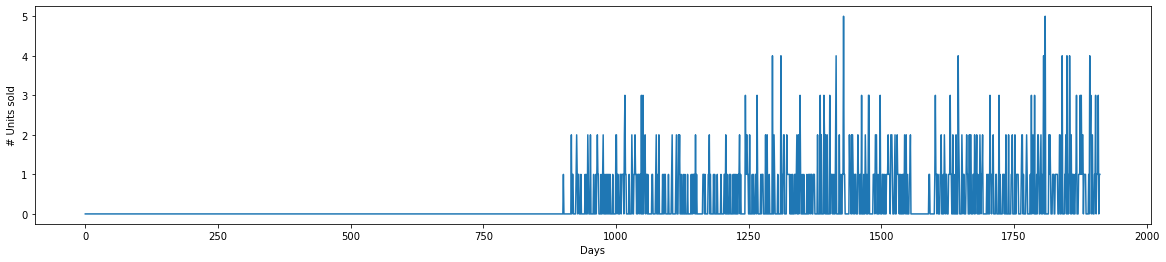

In [ ]:
fig, ax = plt.subplots(figsize=(20, 4))

ax.plot(df_id["units_sold"])
ax.set_xlabel("Days")
ax.set_ylabel("# Units sold")

We can drop all the attributes that describe the price but don't change across rows since they will not provide useful informaton for training a model.

Furthermore, there are many attributes that are redundant and can be removed.

In [ ]:
df_id = df_id.drop(columns=[
    "item_id", "dept_id", "state_id", "cat_id", "store_id", "d", "wm_yr_wk",
    "weekday", "month", "year", "wday"
])
df_id.head()

,units_sold,date,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,0,2011-01-29,None,None,None,None,0,0,0,NaN
1,0,2011-01-30,None,None,None,None,0,0,0,NaN
2,0,2011-01-31,None,None,None,None,0,0,0,NaN
3,0,2011-02-01,None,None,None,None,1,1,0,NaN
4,0,2011-02-02,None,None,None,None,1,0,1,NaN


We observe that for some events we don't have a price. We can assume that in those cases, the price is equal to the oldest price available. 

In [ ]:
df_id["sell_price"] = df_id["sell_price"].bfill()

In [ ]:
df_id.head(10)

,units_sold,date,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,...,lag_7,day_of_month,month,day_of_week,day_of_week_sin,day_of_week_cos,month_cos,month_sin,day_of_month_sin,day_of_month_cos
0,0,2011-01-29,None,None,None,None,0,0,0,9.58,...,NaN,29,1,5,-8.660254e-01,0.5,0.866025,0.500000,-3.943559e-01,0.918958
1,0,2011-01-30,None,None,None,None,0,0,0,9.58,...,NaN,30,1,6,-2.449294e-16,1.0,0.866025,0.500000,-2.012985e-01,0.979530
2,0,2011-01-31,None,None,None,None,0,0,0,9.58,...,NaN,31,1,0,0.000000e+00,1.0,0.866025,0.500000,-2.449294e-16,1.000000
3,0,2011-02-01,None,None,None,None,1,1,0,9.58,...,NaN,1,2,1,8.660254e-01,0.5,0.500000,0.866025,2.012985e-01,0.979530
4,0,2011-02-02,None,None,None,None,1,0,1,9.58,...,NaN,2,2,2,8.660254e-01,-0.5,0.500000,0.866025,3.943559e-01,0.918958
5,0,2011-02-03,None,None,None,None,1,1,1,9.58,...,NaN,3,2,3,1.224647e-16,-1.0,0.500000,0.866025,5.712682e-01,0.820763
6,0,2011-02-04,None,None,None,None,1,0,0,9.58,...,NaN,4,2,4,-8.660254e-01,-0.5,0.500000,0.866025,7.247928e-01,0.688967
7,0,2011-02-05,None,None,None,None,1,1,1,9.58,...,9.58,5,2,5,-8.660254e-01,0.5,0.500000,0.866025,8.486443e-01,0.528964
8,0,2011-02-06,SuperBowl,Sporting,None,None,1,1,1,9.58,...,9.58,6,2,6,-2.449294e-16,1.0,0.500000,0.866025,9.377521e-01,0.347305
9,0,2011-02-07,None,None,None,None,1,1,0,9.58,...,9.58,7,2,0,0.000000e+00,1.0,0.500000,0.866025,9.884683e-01,0.151428


In [ ]:
def build_temporal_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    This function takes `date_variable` which should be a pandas datetype
    and creates several temporal features from it.
    
    In particular, it should create the additional columns in the dataframe
    
    Asume that all variables are in the range [0, x])
    
    
    `day_of_month`
    `month`
    `day_of_week`
    `day_of_week_sin` 
    `day_of_week_cos`
    `month_cos`
    `month_sin`
    `day_of_month_sin`
    `day_of_month_cos`
    `lag_1`
    `lag_7`
    
    Remember to sort the dataframe using the data varaible with the most
    recent values in the bottom.
     
    """
    
    # Write your code here
    ##lag functions
    
    lag_1 =[]
    lag_7=[]

    for index, row in df.iterrows():    
        if index == 0:        
            lag_1.append(None)
            lag_7.append(None)
        elif index >= 1 and index <= 6:
            lag_1.append(df.sort_values('date').iloc[index-1]['sell_price'])
            lag_7.append(None)           
        else:
            lag_1.append(df.sort_values('date').iloc[index-1]['sell_price'])
            lag_7.append(df.sort_values('date').iloc[index-6]['sell_price'])

    df['lag_1'] = lag_1
    df['lag_7'] = lag_7
    
    

    day_of_month = []
    month = []
    day_of_week = []
    day_of_week_sin = []
    day_of_week_cos = []
    month_cos = []
    month_sin = []
    day_of_month_sin = []
    day_of_month_cos = []


    for index, row in df.iterrows():    
        if index >= 0:        
            day_of_month.append(row['date'].day)
            
            month.append(row['date'].month)
            
            day_of_week.append(row['date'].day_of_week)
            
            day_of_week_sin.append(math.sin( (2*math.pi*row['date'].day_of_week)/7))
            
            day_of_week_cos.append(math.cos( (2*math.pi*row['date'].day_of_week)/7))
            
            month_cos.append( math.cos( (2*math.pi*row['date'].month)/12))
            
            month_sin.append(math.sin((2*math.pi*row['date'].month)/12))
            
            day_of_month_sin.append(math.sin( (2*math.pi*row['date'].day)/31))
            
            day_of_month_cos.append(math.cos( (2*math.pi*row['date'].day)/31))

    df['day_of_month']=day_of_month
    df['month']=month
    df['day_of_week']=day_of_week
    df['day_of_week_sin']=day_of_week_sin
    df['day_of_week_cos']=day_of_week_cos
    df['month_cos']=month_cos
    df['month_sin']=month_sin
    df['day_of_month_sin']= day_of_month_sin
    df['day_of_month_cos']=day_of_month_cos
    
    return df

   
    


In [ ]:
# date_variable: str,
df  = build_temporal_features(df_id)

In [ ]:
df.head()

,units_sold,date,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,...,lag_7,day_of_month,month,day_of_week,day_of_week_sin,day_of_week_cos,month_cos,month_sin,day_of_month_sin,day_of_month_cos
0,0,2011-01-29,None,None,None,None,0,0,0,9.58,...,NaN,29,1,5,-0.974928,-0.222521,0.866025,0.500000,-3.943559e-01,0.918958
1,0,2011-01-30,None,None,None,None,0,0,0,9.58,...,NaN,30,1,6,-0.781831,0.623490,0.866025,0.500000,-2.012985e-01,0.979530
2,0,2011-01-31,None,None,None,None,0,0,0,9.58,...,NaN,31,1,0,0.000000,1.000000,0.866025,0.500000,-2.449294e-16,1.000000
3,0,2011-02-01,None,None,None,None,1,1,0,9.58,...,NaN,1,2,1,0.781831,0.623490,0.500000,0.866025,2.012985e-01,0.979530
4,0,2011-02-02,None,None,None,None,1,0,1,9.58,...,NaN,2,2,2,0.974928,-0.222521,0.500000,0.866025,3.943559e-01,0.918958


In [ ]:
df.iloc[1010:1021]

,units_sold,date,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,...,lag_7,day_of_month,month,day_of_week,day_of_week_sin,day_of_week_cos,month_cos,month_sin,day_of_month_sin,day_of_month_cos
1010,0,2013-11-04,None,None,None,None,1,0,0,8.26,...,8.26,4,11,0,0.000000e+00,1.0,0.866025,-0.5,0.724793,0.688967
1011,1,2013-11-05,None,None,None,None,1,1,1,8.26,...,8.26,5,11,1,8.660254e-01,0.5,0.866025,-0.5,0.848644,0.528964
1012,1,2013-11-06,None,None,None,None,1,1,1,8.26,...,8.26,6,11,2,8.660254e-01,-0.5,0.866025,-0.5,0.937752,0.347305
1013,1,2013-11-07,None,None,None,None,1,1,0,8.26,...,8.26,7,11,3,1.224647e-16,-1.0,0.866025,-0.5,0.988468,0.151428
1014,1,2013-11-08,None,None,None,None,1,0,1,8.26,...,8.26,8,11,4,-8.660254e-01,-0.5,0.866025,-0.5,0.998717,-0.050649
1015,0,2013-11-09,None,None,None,None,1,1,1,8.26,...,8.26,9,11,5,-8.660254e-01,0.5,0.866025,-0.5,0.968077,-0.250653
1016,2,2013-11-10,None,None,None,None,1,0,0,8.26,...,8.26,10,11,6,-2.449294e-16,1.0,0.866025,-0.5,0.897805,-0.440394
1017,3,2013-11-11,VeteransDay,National,None,None,0,1,1,8.26,...,8.26,11,11,0,0.000000e+00,1.0,0.866025,-0.5,0.790776,-0.612106
1018,1,2013-11-12,None,None,None,None,0,1,1,8.26,...,8.26,12,11,1,8.660254e-01,0.5,0.866025,-0.5,0.651372,-0.758758
1019,1,2013-11-13,None,None,None,None,0,1,0,8.26,...,8.26,13,11,2,8.660254e-01,-0.5,0.866025,-0.5,0.485302,-0.874347


In [ ]:
row = df.iloc[1020]
# assert np.allclose(row["day_of_week"], 3)
# assert np.allclose(row["day_of_month"], 14)
assert np.allclose(row["month_sin"], -0.866025)
assert np.allclose(row["month_cos"], 0.5)
# assert np.allclose(row["day_of_week_sin"], 0.433884)
# assert np.allclose(row["day_of_week_cos"], -0.222521)
# assert np.allclose(row["day_of_month_cos"], -0.874347)
# assert np.allclose(row["lag_1"], 1)
# assert np.allclose(row["lag_2"], 1)
# assert np.allclose(row["lag_14"], 0)

answer_month = row["month"]
answer_month_sin = row["day_of_month_sin"]
answer_lag7 = row["lag_7"]

print(answer_month)
print(answer_month_sin)
print(answer_lag7)

AssertionError: 

# Splitting the dataset

Unlike normal problems with tabular data, we can't randomly split the data (since each row has a temporal component).

For this we will manually split the dataset and keep the last 30 as test data.

In [ ]:
y = df.pop("units_sold")
X = df.copy()

In [ ]:
X_train, y_train = X.iloc[:-30], y.iloc[:-30]
X_test, y_test = X.iloc[-30:], y.iloc[-30:]

In [ ]:
X_train.shape, y_train.shape

In [ ]:
X_test.shape, y_test.shape

# Training with a simple AR model

In [ ]:
arima = ARIMA(y_train, order=(7, 1, 0))
arima_res = arima.fit()

In [ ]:
y_pred = arima_res.forecast(steps=30)[0]

In [ ]:
mean_squared_error(y_pred, y_test.values, squared=True)

In [ ]:
fig, ax = plt.subplots()
ax.plot(y_pred, label="predicted")
ax.plot(y_test.values, label="original")
ax.legend()

# Training using ML with Tabular Data

For simplicity we are going to use only the numerical features, without trying to properly encode the other ones.

In [ ]:
params = {
    'max_depth': 4,
    'learning_rate': 0.01,
    'n_estimators': 450,
    'boosting_type': 'gbdt',
    'seed': 200,
    'num_threads': 1
}

model = lgb.LGBMRegressor(**params)

model.fit(X_train.select_dtypes(include=["float", "int"]), y_train)

In [ ]:
y_pred = model.predict(X_test.select_dtypes(include=["float", "int"]))

In [ ]:
mean_squared_error(y_pred, y_test.values, squared=True)

In [ ]:
fig, ax = plt.subplots()
ax.plot(y_pred, label="predicted", marker="*")
ax.plot(y_test.values, label="original", marker="o")
ax.legend()

# Summary

We showed how we can build a tabular dataset from a time-series and how we can use traditional techniques such as `Regression Trees` to train such model.

In this example our analysis was quite basic and we kept only a minium number of variables.

Furthermore, an approach that was not explored is to train several items at the same (which requires more computing power), which can further incrase the performance of the model.

In [ ]:

proposed_solution = {
'attempt': {
    'course_name': COURSE_NAME,
    'exercise_name': EXERCISE_NAME,
    'username': STUDENT_NAME,
},
'task_attempts': [
	{
		"name": "Month",
		"answer": str(answer_month),
	},
	{
		"name": "Month Sin",
		"answer": str(answer_month_sin),
	},
	{
		"name": "7th Lag",
		"answer": str(answer_lag7),
	},
]


}
check_solution(proposed_solution)
    